In [ ]:
import pandas as pd
import string
from string import digits
import re
import os
from numpy import array, argmax, random, take
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, RepeatVector,TimeDistributed
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
english_sentances = []
telugu_sentances = []
with open("/content/drive/MyDrive/english_telugu_data.txt", mode='rt', encoding='utf-8') as fp:
    for line in fp.readlines():
        eng_tel = line.split("++++$++++")
        english_sentances.append(eng_tel[0])
        telugu_sentances.append(eng_tel[1])

In [ ]:
data = pd.DataFrame({"english_sentances":english_sentances,"telugu_sentances":telugu_sentances})

In [ ]:
data.head()

,english_sentances,telugu_sentances
0,His legs are long.,అతని కాళ్ళు పొడవుగా ఉన్నాయి.\n
1,Who taught Tom how to speak French?,టామ్ ఫ్రెంచ్ మాట్లాడటం ఎలా నేర్పించారు?\n
2,I swim in the sea every day.,నేను ప్రతి రోజు సముద్రంలో ఈత కొడతాను.\n
3,Tom popped into the supermarket on his way hom...,టామ్ కొంచెం పాలు కొనడానికి ఇంటికి వెళ్ళేటప్పుడ...
4,Smoke filled the room.,పొగ గదిని నింపింది.\n


In [ ]:
data.shape

(155798, 2)

In [ ]:
data = data.iloc[:70000,:]

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [ ]:
def clean_eng(text):

    text = text.lower()

    text = ' '.join([contraction_mapping[w] if w in contraction_mapping else w for w in text.split(" ")])

    text = re.sub("'", '', text)

    exclude = set(string.punctuation)
    text = ''.join([c for c in text if c not in exclude])

    remove_digits = str.maketrans('', '', digits)
    text = text.translate(remove_digits)

    text= text.strip()

    return text

In [ ]:
def clean_tel(text):

    text = text.lower()

    text = re.sub("'", '', text)

    exclude = set(string.punctuation)
    text = ''.join([c for c in text if c not in exclude])

    remove_digits = str.maketrans('', '', digits)
    text = text.translate(remove_digits)

    text = re.sub("[౦౧౨౩౪౫౬౭౮౯]", '', text)

    text= text.strip()

    return text

In [ ]:
def clean_tel(text):

    text = text.lower()

    text = re.sub("'", '', text)

    exclude = set(string.punctuation)
    text = ''.join([c for c in text if c not in exclude])

    remove_digits = str.maketrans('', '', digits)
    text = text.translate(remove_digits)

    text = re.sub("[౦౧౨౩౪౫౬౭౮౯]", '', text)

    text= text.strip()

    return text

In [ ]:
data_df = data.copy()
data_df["english_sentances"] = data_df["english_sentances"] .apply(lambda x: clean_eng(x))
data_df["telugu_sentances"] = data_df["telugu_sentances"] .apply(lambda x: clean_tel(x))

In [ ]:
data_df.head()

,english_sentances,telugu_sentances
0,his legs are long,అతని కాళ్ళు పొడవుగా ఉన్నాయి
1,who taught tom how to speak french,టామ్ ఫ్రెంచ్ మాట్లాడటం ఎలా నేర్పించారు
2,i swim in the sea every day,నేను ప్రతి రోజు సముద్రంలో ఈత కొడతాను
3,tom popped into the supermarket on his way hom...,టామ్ కొంచెం పాలు కొనడానికి ఇంటికి వెళ్ళేటప్పుడ...
4,smoke filled the room,పొగ గదిని నింపింది


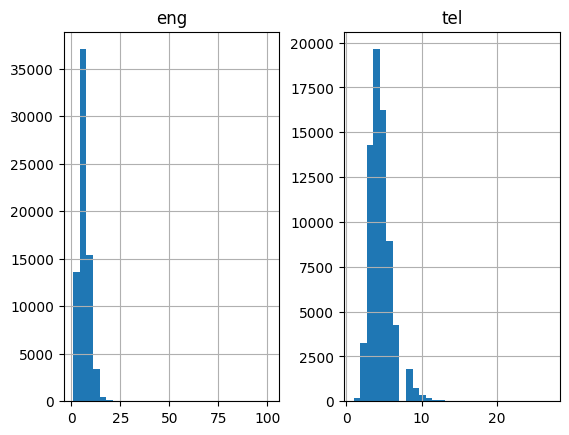

In [ ]:

eng_l = []
tel_l = []

for i in data_df["english_sentances"].values:
      eng_l.append(len(i.split()))

for i in data_df["telugu_sentances"].values:
      tel_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'tel':tel_l})

length_df.hist(bins = 30)
plt.show()

In [ ]:
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [ ]:
eng_tokenizer = tokenization(data_df["english_sentances"])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 43
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 10315


In [ ]:
tel_tokenizer = tokenization(data_df["telugu_sentances"])
tel_vocab_size = len(tel_tokenizer.word_index) + 1

tel_length = 26
print('Telugu Vocabulary Size: %d' % tel_vocab_size)

Telugu Vocabulary Size: 26680


In [ ]:
def encode_sequences(tokenizer, length, lines):

    seq = tokenizer.texts_to_sequences(lines)

    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [ ]:
train, test = train_test_split(data_df, test_size=0.2, random_state = 12)

In [ ]:
trainX = encode_sequences(eng_tokenizer, eng_length, train["english_sentances"])
trainY = encode_sequences(tel_tokenizer, tel_length, train["telugu_sentances"])


testX = encode_sequences(eng_tokenizer, eng_length, test["english_sentances"])
testY = encode_sequences(tel_tokenizer, tel_length, test["telugu_sentances"])

In [ ]:
trainX

array([[   1,   34,   12, ...,    0,    0,    0],
       [   1,  340,    3, ...,    0,    0,    0],
       [  12,    7,   38, ...,    0,    0,    0],
       ...,
       [  15, 1161,   20, ...,    0,    0,    0],
       [  10,    7,   24, ...,    0,    0,    0],
       [   2,  152,   11, ...,    0,    0,    0]], dtype=int32)

In [ ]:
trainX.shape,trainY.shape,testX.shape,testY.shape

((56000, 43), (56000, 26), (14000, 43), (14000, 26))

In [ ]:
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(TimeDistributed(Dense(out_vocab, activation='softmax')))
    return model

In [ ]:
model = define_model(eng_vocab_size,tel_vocab_size,eng_length,tel_length, 512)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
rms = optimizers.RMSprop()
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [ ]:

filepath = '/content/drive'+'NMT_model.keras'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

reduce_alpha = ReduceLROnPlateau(monitor ='val_loss', factor = 0.2, patience = 1, min_lr = 0.001)

callbacks = [checkpoint, reduce_alpha]

In [ ]:
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=3, batch_size=128, validation_split = 0.2,callbacks=callbacks, verbose=1)

Epoch 1/3
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - loss: 2.3685 
Epoch 1: val_loss improved from inf to 1.33778, saving model to /content/driveNMT_model.keras
350/350 ━━━━━━━━━━━━━━━━━━━━ 5396s 15s/step - loss: 2.3664 - val_loss: 1.3378 - learning_rate: 0.0010
Epoch 2/3
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - loss: 1.3249 
Epoch 2: val_loss improved from 1.33778 to 1.32704, saving model to /content/driveNMT_model.keras
350/350 ━━━━━━━━━━━━━━━━━━━━ 5511s 16s/step - loss: 1.3248 - val_loss: 1.3270 - learning_rate: 0.0010
Epoch 3/3
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - loss: 1.3031 
Epoch 3: val_loss improved from 1.32704 to 1.30341, saving model to /content/driveNMT_model.keras
350/350 ━━━━━━━━━━━━━━━━━━━━ 5507s 16s/step - loss: 1.3030 - val_loss: 1.3034 - learning_rate: 0.0010


In [ ]:
import keras

In [ ]:
model = keras.saving.load_model(filepath)

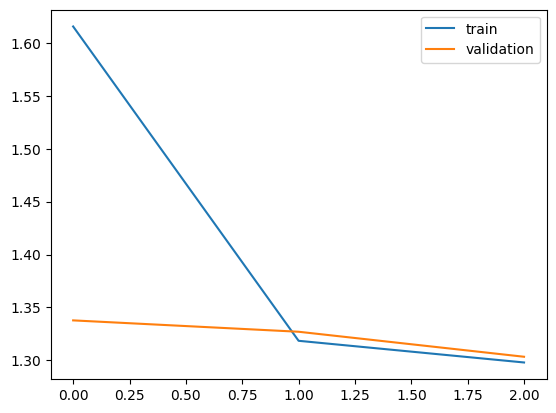

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [ ]:
idx = random.randint(testX.shape[0], size=10)

encoded_english_actual = testX[idx,:]

eng_actual = test["english_sentances"].values
eng_actual = eng_actual[idx]

actual = test["telugu_sentances"].values
actual = actual[idx]

In [ ]:
preds = model.predict(encoded_english_actual.reshape((encoded_english_actual.shape[0],encoded_english_actual.shape[1])))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [ ]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [ ]:
import numpy as np

def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

preds = model.predict(encoded_english_actual)


if preds.ndim == 3:
    preds = np.argmax(preds, axis=-1)


decoded_sentences = []
for pred in preds:
    sentence = []
    for token_index in pred:
        if token_index == 0:
            break
        word = get_word(token_index, tel_tokenizer)
        if word is not None:
            sentence.append(word)
    decoded_sentences.append(' '.join(sentence))


for i in range(5):
    print(f"English: {' '.join([get_word(idx, eng_tokenizer) for idx in encoded_english_actual[i] if idx != 0])}")
    print(f"Predicted Telugu: {decoded_sentences[i]}")
    print()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
English: i miss my children
Predicted Telugu: టామ్ చాలా

English: i really wanted to go to toms concert but it was sold out
Predicted Telugu: టామ్ మరియు నేను నేను నేను

English: he should have arrived by now
Predicted Telugu: టామ్ చాలా నేను

English: tom asked mary how she was doing
Predicted Telugu: టామ్ మరియు నేను నేను

English: the building fell down
Predicted Telugu: టామ్ చాలా

